[Kaggle Competition](https://www.kaggle.com/c/nfl-big-data-bowl-2021)

Purpose of this notebook is to generate prediction models for the coverage type, based on 2018 week 1 labels provided in the competition.

Reason behind building a coverage label prediction model is to label plays for all other weeks (2-17) and then use that as an additional feature of downstream analytics, either at the play-level or tracking data within plays of a specific coverage type.

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import nflutil

Loading the data:

In [4]:
week_num = 1

track_df = pd.read_csv(f'csv/week{week_num}.csv')
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df = pd.read_csv('csv/players.csv')
coverage_df = pd.read_csv('csv/coverages_week1.csv')

# Generate Features

Features are generated on a per-play basis to predict the overall defensive coverage scheme.

Unless specified as the value at a particular stage of the play (snap, throw, etc.), the features are calculated at each time step between the snap and a "pivot" event that will alter the behavior of the defense (i.e. throw or sack) or a maximum elapsed time after the snap, whichever is first. The maximum time is meant to limit the effect of the play breaking down on the planned movements of the players.

All defenders are evaluated at a threshold time in the play (e.g. 1.5 seconds after snap) if they are still beyond the line of scrimmage to determine which defenders are actually in coverage vs. blitzing. Blitzing player values would skew average results, and the movement of the rusher does not matter beyond the fact that they are not in coverage.

The following features are generated at a per-defender level (inspired by [this paper](https://arxiv.org/abs/1906.11373)), then averaged across all coverage defenders:

* **depth_mean**: average yards downfield of the defender (same as X_mean but normalizes for line of scrimmage)
* **depth_var**: variance in downfield movement (same as X_var, lower value expected for zone)
* **y_mean**: average horizontal location of defender
* **y_var**: variance in horizontal movement (lower value expected for zone)
* **speed_mean**: average speed of the defender, yd/sec (lower value expected for zone)
* **speed_var**: variance in speed of the defender (lower expected for zone)
* **off_mean**: average distance to the closest offensive player at each frame during a play (lower expected for man)
* **off_var**: variance in distance to the closest offensive player at each frame (lower expected for man)
* **def_mean**: average distance to the closest defender at each frame
* **def_var**: variance in distance to the closest defender at each frame
* **rat_mean**: see paper for better description
* **rat_var**: see paper for better description

New features: 

* **rat_o_los**: ratio of time during a play that a defender is facing the QB/line of scrimmage. Expected to be near 1 for zone (reading the QB's eyes, keeping receivers in front of them vs. turning and running with the receiver) **Current threshold is 60 degrees (240-300 deg) to account for man coverage following crossing routes or moving mostly sideways but slightly towards the LOS**

The following play-level features are generated:

* **n_cover**: the number of defenders with tracking data in coverage (beyond the LOS at t_defender_thresh sec)
* **n_cb**: the number of cornerbacks in the defensive formation
* **n_def_excess**: the number of coverage defenders minus eligible receivers (players available for zone or double coverage)

The following features are evaluated based on player locations at the snap (leverage info when defense do not disguise coverage pre-snap):
* **n_deep_snap**: the number of defenders over 10 yards downfield at the snap
* **cb_depth_snap_min**: depth of closest CB to the LOS (press vs. soft)
* **cb_depth_snap_mean**: average depth of CBs
* **cb_depth_snap_max**: depth of farther CB to the LOS (zone expected for far off the ball)

The following features are evaluated at the "freeze" time (determining which players are in coverage, coverage scheme is assumed to be materialized regardless if it was being disguised pre-snap or not):
* **n_deep_frz**: number of defenders over 10 yards downfield at "freeze"
* **def_spac_frz_avg**: spacing to nearest defender at "freeze", averaged over all coverage players
* **def_spac_frz_min**: same source as above, but minimum (larger expected for zone)
* **def_spac_frz_max**: same source as above, but maximum (smaller expected for zone)
* **cb_depth_frz_min**: same as at snap but at the "freeze" time
* **cb_depth_frz_mean**: same as at snap but at the "freeze" time
* **cb_depth_frz_max**: same as at snap but at the "freeze" time

In [5]:
def create_play_features(play_track_df, game_df, play_df, t_defender_thresh=1.5, t_scheme_develop=3, t_reaction_time=0, plot_o=False):
    ### THE INPUT TRACKING DATA MUST BE NORMALIZED FOR DIRECTION BEFORE INPUT INTO THIS FUNCTION
    # inputs:
    #     - play_track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - t_defender_thresh: time in seconds after the snap to determine which players are in coverage
    #     - t_scheme_develop: time in seconds after the snap to set as a max time threshold
    #                         (i.e. before the play breaks down, after which the movement 
    #                          is not always indicative of the coverage scheme)
    #     - t_reaction_time: time in seconds after the ball thrown to continue taking statistics (paths
    #                        won't change until players realize the ball has been thrown)
    
    # local constants
    DEF_DEEP_THRESH = 10  # yards behind the line of scrimmage considered "deep" coverage

    # work on a copy of the data rather than the actual data (for temporary features)
    play_track_df = play_track_df.copy()
    
    # get the current play gameId and playId
    game_id = play_track_df.gameId.iloc[0]
    play_id = play_track_df.playId.iloc[0]
    
    # determine who has the ball (team code)
    home_abbr = game_df[game_df.gameId==game_id].iloc[0]['homeTeamAbbr']
    away_abbr = game_df[game_df.gameId==game_id].iloc[0]['visitorTeamAbbr']
#     print(f'Home: {home_abbr}')
#     print(f'Away: {away_abbr}')
    
    abbr_possess = play_df[(play_df.gameId==game_id) & (play_df.playId==play_id)].iloc[0]['possessionTeam']
#     print(f'Possess: {abbr_possess}')
    
    if abbr_possess == home_abbr:
        team_poss = 'home'
        team_def = 'away'
    else:
        team_poss = 'away'
        team_def = 'home'
        
#     print(f'team_poss: {team_poss}')
#     print(f'team_def: {team_def}')
    
    # ------------- FEATURE GENERATION SETUP/INTERMEDIATE CALCULATIONS ----------------------
    
#     # make a dictionary of nflId to position for each player in the play
#     player_positions = play_track_df.groupby('nflId')[['nflId', 'position']].head(1).dropna()  # football is np.nan
#     position_dict = dict(zip(player_positions['nflId'].tolist(), player_positions['position'].tolist()))
    
    # get play information
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]
    
    # save the distance downfield of all observations relative to the line of scrimmage
    play_track_df['depth'] = play_track_df['x'] - x_los
    
    # get frameId for specific points in the play (exclude handoff: not a material pivot part of the play,
    # also sometimes occurs prior to the snap)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']
    
    frame_max = play_track_df.frameId.max()
    frame_snap = play_track_df[play_track_df.event=='ball_snap']['frameId'].iloc[0]
    if np.any(play_track_df.event.isin(pivot_events)):
        # find the frameId of the earliest of the pivot events
        # - account for errors on individual players: group by event, find the median frame for each event, then
        #   take the minimum of the medians to get the first event (essentially voting then min)
        frame_pivot = (play_track_df.loc[play_track_df.event.isin(pivot_events), ['event', 'frameId']]
                       .groupby('event').median().min().iloc[0]
                       + int(round(10 * t_reaction_time)))
    else:
        frame_pivot = frame_max
    
    # important frameId's in the play:
    frame_start = frame_snap
    frame_cover_freeze = min(frame_max, frame_pivot, int(round(frame_snap + 10*t_defender_thresh)))
    frame_scheme_develop = int(frame_snap + round(10*t_scheme_develop))
    frame_end = min(frame_pivot, frame_scheme_develop, frame_max)
    
#     print(f'frame_start: {frame_start}')
#     print(f'frame_cover_freeze: {frame_cover_freeze}')
#     print(f'frame_scheme_develop: {frame_scheme_develop}')
#     print(f'frame_end: {frame_end}')
#     print(f'frame_max: {frame_max}')
    
    
    # filter out data from frames outside of the range (frame_start <= F <= frame_end)
    play_track_df = play_track_df[(play_track_df.frameId >= frame_start) & (play_track_df.frameId <= frame_end)]
    
    
    # ----- SAVE SLICES OF DATAFRAME FOR DEFENDERS AND COVERAGE AND ELIGIBLE RECEIVERS ----
    
    # get defensive player tracks that are in coverage (i.e. not blitzing/rushing the passer)
    def_positions = ['DE', 'DL', 'NT', 'LB', 'MLB', 'ILB', 'OLB', 'DB', 'CB', 'FS', 'SS', 'S']
    cover_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_def) & 
                          (play_track_df.depth > 0)]
    def_track = play_track_df[play_track_df.nflId.isin(cover_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # get offensive player tracks of eligible receivers (minus QB)
    off_positions = ['WR', 'RB', 'TE', 'FB', 'HB']
    off_track = play_track_df[(play_track_df.team == team_poss) & (play_track_df.position != 'QB')].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_poss) & 
                          (play_track_df.depth > 0)]
    # edge case where there are no downfield receivers at the time of throw: quick screen,
    # goal-line, etc. --> use all offensive players
    if len(downfield_players) == 0:
        downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_poss) &
                          (play_track_df.position != 'QB')]
    
    downfield_track = play_track_df[play_track_df.nflId.isin(downfield_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # ----- MAN COVERAGE FEATURES --------------------------------------------------------
    
    # get attributes for the outermost receivers and defenders at the snap to build man coverage features
    min_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_def), 'y'].idxmin()
    max_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_def), 'y'].idxmax()
    right_def_nfl_id = play_track_df.nflId.loc[min_def_y_idx]
    left_def_nfl_id = play_track_df.nflId.loc[max_def_y_idx]

    outer_def_x = np.hstack([play_track_df.x[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.x[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1,1)])
    outer_def_y = np.hstack([play_track_df.y[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.y[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1,1)])
    
    min_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_poss), 'y'].idxmin()
    max_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_poss), 'y'].idxmax()
    right_off_nfl_id = play_track_df.nflId.loc[min_off_y_idx]
    left_off_nfl_id = play_track_df.nflId.loc[max_off_y_idx]

    outer_off_x = np.hstack([play_track_df.x[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.x[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    outer_off_y = np.hstack([play_track_df.y[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.y[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    outer_off_dis = np.hstack([play_track_df.dis[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.dis[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    
    # calculate total distance travelled by receivers during their route
    route_length = np.sum(outer_off_dis, axis=0)
    
    # calculate the distance between the outer defenders at start of play to corresponding receiver
    # at pivot play
    outer_spacing_end = np.sqrt((outer_def_x[-1,:] - outer_off_x[-1,:])**2
                                + (outer_def_y[-1,:] - outer_off_y[-1,:])**2)
    
    # calculate ratio of route length to end spacing. Higher ratios are likely to be man coverage
    # -- (1) Gives higher weight to longer routes: more distance to determine man/zone (stronger signal)
    # -- (2) Dropping off of a route to cover a zone (large end spacing) will create a smaller ratio
    game_id = play_track_df['gameId'].iloc[0]
    play_id = play_track_df['playId'].iloc[0]
    
#     # debug warning handling:
#     if np.any(np.isnan(route_length)):
#         print(f'Route Length NAN in game {game_id}, play {play_id}: {route_length}')
#     if np.any(np.isnan(outer_spacing_end)):
#         print(f'Outer Spacing End NAN in game {game_id}, play {play_id}: {outer_spacing_end}')
    rat_route_spacing = route_length / outer_spacing_end
    
    # -- Determine if the defender shadows outside or inside of the outer receiver:
    # -- inner likely man, outer likely zone. look at snap and aggregate until throw
    # distance from the middle of the field 
    dist_def_mid = np.abs(53.3/2 - outer_def_y)
    dist_off_mid = np.abs(53.3/2 - outer_off_y)
    # def - off: positive if defender is outside, negative if defender is inside
    dist_shadow_out = dist_def_mid - dist_off_mid
    # at snap
    dist_shadow_out_snap = dist_shadow_out[0,:]
    # aggregate over play
    dist_shadow_out_play = np.nanmean(dist_shadow_out, axis=0)
    
    # ------ PLAY CHARACTERISTICS AT SPECIFIC FRAMES/POINTS IN TIME -----------------------
    
    # find characteristics of scheme at the snap (line of scrimmage naturally divides offense + defense)
    n_deep_snap = np.sum((play_track_df.depth >= DEF_DEEP_THRESH) & (play_track_df.frameId == frame_start))
    cb_id = play_track_df[play_track_df.position=='CB']['nflId'].unique()
    n_cb = len(cb_id)
    
    if n_cb > 0:
        # depth at snap
        cb_depth_at_snap = play_track_df.loc[(play_track_df.frameId == frame_start) 
                                             & (play_track_df.nflId.isin(cb_id)), 'depth']
        # is oriented towards LOS pre-snap
        los_orient_thresh = 15  # degrees
        cb_o_snap = play_track_df.loc[(play_track_df.frameId == frame_start) 
                                      & (play_track_df.nflId.isin(cb_id)), 'o']
        cb_o_snap_to_los = np.abs(cb_o_snap - 270)
        cb_o_snap_to_los_flag = (cb_o_snap > (270 - los_orient_thresh)) & (cb_o_snap < (270 + los_orient_thresh))
        
        if plot_o:
            sns.lineplot(data=play_track_df.loc[play_track_df.nflId.isin(cb_id)],
                        x='frameId', y='o', hue='nflId')
#         print(cb_o_snap)
#         print(cb_o_snap_to_los)
#         print(cb_o_snap_to_los_flag)
        
    
    # find characteristics of players in coverage at the "cover freeze time"
    n_deep_freeze = np.sum((play_track_df.nflId.isin(cover_players)) & 
                           (play_track_df.depth >= DEF_DEEP_THRESH) &
                           (play_track_df.frameId == frame_cover_freeze))
    cb_depth_at_freeze = play_track_df.loc[(play_track_df.frameId == frame_cover_freeze) & (play_track_df.position=='CB'), 'depth']
    
    # calculate the number of "excess defenders" (available for free zone or double coverage)
    # - negative either means uncovered, or potential receiver stays back in protection
    n_def_excess = len(cover_players) - len(play_track_df.nflId[play_track_df.team == team_poss].unique())
    
    
    # ------GENERATE FEATURES FOR EACH COVERAGE PLAYER AT EACH FRAME ---------------------
    
    feature_data = {'depth_mean': [],
                    'depth_var': [],
                    'y_mean': [],
                    'y_var': [],
                    'speed_mean': [],
                    'speed_var': [],
                    'off_mean': [],
                    'off_var': [],
                    'off_dir_mean': [],
                    'off_dir_var': [],
                    'def_mean': [],
                    'def_var': [],
                    'rat_mean': [],
                    'rat_var': [],
                    'rat_o_los': []
                   }
    
    # data that is not dependent on the specific player
    x_off = off_track['x'].to_numpy()  # (n_frame, n_off) array
    y_off = off_track['y'].to_numpy()  # (n_frame, n_off) array
    dir_off = off_track['dir'].to_numpy()  # (n_frame, n_off) array
    x_def_full = def_track['x'].to_numpy()  # (n_frame, n_def) array
    y_def_full = def_track['y'].to_numpy()  # (n_frame, n_def) array
    
    # preallocate numpy array for minimum distance to nearest defensive player for each frame
    dist_def_min_array = np.empty([len(play_track_df.frameId.unique()), len(cover_players)])
    dist_def_min_array[:] = np.nan
    
    # loop over each cover player --------------------------------------------------------
    for i, player in enumerate(cover_players):
        x_player = def_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        depth_player = def_track['depth'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = def_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        s_player = def_track['s'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        o_player = def_track['o'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        dir_player = def_track['dir'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        
        x_def = def_track['x'].drop(columns=player).to_numpy()  # (n_frame, n_def-1) array
        y_def = def_track['y'].drop(columns=player).to_numpy()  # (n_frame, n_def-1) array
        
        # calculate distance to each player at each time
        dist_off = np.sqrt((x_player - x_off)**2 + (y_player - y_off)**2)  # (n_frame, n_off) array
        dist_off_min = np.nanmin(dist_off, axis=1) # (n_frame,) array
        dist_def = np.sqrt((x_player - x_def)**2 + (y_player - y_def)**2)  # (n_frame, n_off) array
        dist_def_min = np.nanmin(dist_def, axis=1) # (n_frame,) array
        
        # save minimum distances for each player in external array
        dist_def_min_array[:, i] = dist_def_min
        
        # get the direction of the closest offensive player at each time
        dir_off_min = dir_off[dist_off == dist_off_min.reshape(-1,1)]  # (n_frame,) array
        # calculate the difference between the defender direction and offense direction, accounting for 0-360 wrap
        dir_diff_m360 = dir_player - dir_off_min - 360  # min when defender dir = 359, offense dir = 0
        dir_diff = dir_player - dir_off_min             # min when wrap is not an issue (defender = 10, offense = 11)
        dir_diff_p360 = dir_player - dir_off_min + 360  # min when defender dir = 0, offense dir = 359
        temp_dir_compare = np.where(np.abs(dir_diff_m360) < np.abs(dir_diff), dir_diff_m360, dir_diff)
        dir_diff_min = np.where(np.abs(temp_dir_compare) < np.abs(dir_diff_p360), temp_dir_compare, dir_diff_p360)
        
        # calculate ratio of distance to closest offensive player "j" (d_i-j) and distance from same offensive player
        # to defensive player "k" nearest to current player (d_j-k)
        x_j = x_off[dist_off == dist_off_min.reshape(-1,1)]  # (n_frame,) array
        y_j = y_off[dist_off == dist_off_min.reshape(-1,1)]  # (n_frame,) array
        x_k = x_def[dist_def == dist_def_min.reshape(-1,1)]  # (n_frame,) array
        y_k = y_def[dist_def == dist_def_min.reshape(-1,1)]  # (n_frame,) array
        ratio = dist_off_min / np.sqrt((x_j - x_k)**2 + (y_j - y_k)**2)
        
        # calculate the ratio of frames a defender is facing the line of scrimmage
        o_los_thresh = 30
        rat_o_los = np.nanmean((o_player > (270 - o_los_thresh)) & (o_player < (270 + o_los_thresh)))
        
        # save average distance
        feature_data['depth_mean'].append(np.nanmean(depth_player))
        feature_data['depth_var'].append(np.nanvar(depth_player))
        feature_data['y_mean'].append(np.nanmean(y_player))
        feature_data['y_var'].append(np.nanvar(y_player))
        feature_data['speed_mean'].append(np.nanmean(s_player))
        feature_data['speed_var'].append(np.nanvar(s_player))
        feature_data['off_mean'].append(np.nanmean(dist_off_min))
        feature_data['off_var'].append(np.nanvar(dist_off_min))
        feature_data['off_dir_mean'].append(np.nanmean(dir_diff_min))
        feature_data['off_dir_var'].append(np.nanvar(dir_diff_min))
        feature_data['def_mean'].append(np.nanmean(dist_def_min))
        feature_data['def_var'].append(np.nanvar(dist_def_min))
        feature_data['rat_mean'].append(np.nanmean(ratio))
        feature_data['rat_var'].append(np.nanvar(ratio))
        feature_data['rat_o_los'].append(rat_o_los)
        
    # put results into a dataframe
    def_df = pd.DataFrame(feature_data, index=cover_players)
    
    # loop over each downfield offensive player -----------------------------------
    downfield_data = {
        'df_rec_space_mean': [],
        'df_rec_space_var': []
    }
    for i, player in enumerate(downfield_players):
        # extract location of player and put as column vector
        x_player = downfield_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = downfield_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        
        # calculate distance to each defensive at each time
        dist_to_defender = np.sqrt((x_player - x_def_full)**2 + (y_player - y_def_full)**2)  # (n_frame, n_def) array
        # get distance to closest defender
        dist_to_defender_min = np.nanmin(dist_to_defender, axis=1) # (n_frame,) array
        
        # save average of distance to closest defender
        downfield_data['df_rec_space_mean'].append(np.nanmean(dist_to_defender_min))
        downfield_data['df_rec_space_var'].append(np.nanvar(dist_to_defender_min))
    
    # put results into a dataframe
    downfield_df = pd.DataFrame(downfield_data, index=downfield_players)
    
    # return averages of all coverage players
    out_data = pd.concat([def_df.mean(), downfield_df.mean()])
    out_data['n_cover'] = len(cover_players)
    out_data['n_cb'] = n_cb
    out_data['n_deep_snap'] = n_deep_snap
    out_data['n_deep_frz'] = n_deep_freeze
    out_data['n_def_excess'] = n_def_excess
    out_data['def_spac_frz_avg'] = np.nanmean(dist_def_min_array[frame_cover_freeze - frame_start, :])
    out_data['def_spac_frz_min'] = np.nanmin(dist_def_min_array[frame_cover_freeze - frame_start, :])
    
    # add in man-coverage specific features
    out_data['rat_route_spac'] = np.nanmean(rat_route_spacing)
    out_data['dist_shadow_out_snap_min'] = np.min(dist_shadow_out_snap)
    out_data['dist_shadow_out_snap_mean'] = np.mean(dist_shadow_out_snap)
    out_data['dist_shadow_out_snap_max'] = np.max(dist_shadow_out_snap)
    out_data['dist_shadow_out_play_min'] = np.min(dist_shadow_out_play)
    out_data['dist_shadow_out_play_mean'] = np.mean(dist_shadow_out_play)
    out_data['dist_shadow_out_play_max'] = np.max(dist_shadow_out_play)
    
    # add in CB-specific features
    if n_cb > 0:
        out_data['cb_depth_snap_min'] = np.nanmin(cb_depth_at_snap)
        out_data['cb_depth_snap_mean'] = np.nanmean(cb_depth_at_snap)
        out_data['cb_depth_snap_max'] = np.nanmax(cb_depth_at_snap)
        out_data['cb_depth_frz_min'] = np.nanmin(cb_depth_at_freeze)
        out_data['cb_depth_frz_mean'] = np.nanmean(cb_depth_at_freeze)
        out_data['cb_depth_frz_max'] = np.nanmax(cb_depth_at_freeze)
        out_data['cb_o_snap_to_los_min'] = np.nanmin(cb_o_snap_to_los)
        out_data['cb_o_snap_to_los_mean'] = np.nanmean(cb_o_snap_to_los)
        out_data['cb_o_snap_to_los_max'] = np.nanmax(cb_o_snap_to_los)
        out_data['cb_o_snap_to_los_flag'] = np.nanmean(cb_o_snap_to_los_flag)
    else:
        out_data['cb_depth_snap_min'] = 0
        out_data['cb_depth_snap_mean'] = 0
        out_data['cb_depth_snap_max'] = 0
        out_data['cb_depth_frz_min'] = 0
        out_data['cb_depth_frz_mean'] = 0
        out_data['cb_depth_frz_max'] = 0
        out_data['cb_o_snap_to_los_min'] = 0
        out_data['cb_o_snap_to_los_mean'] = 0
        out_data['cb_o_snap_to_los_max'] = 0
        out_data['cb_o_snap_to_los_flag'] = 0
        
    
    return out_data
    
# test the function
game_id = 2018090901
play_id = 3325
play_track_df = track_df[(track_df.gameId==game_id) & (track_df.playId == play_id)]
test_df = nflutil.transform_tracking_data(play_track_df)
# out=create_play_features(test_df, plot_o=True)
out=create_play_features(test_df, game_df, play_df)
out

depth_mean                      8.229960
depth_var                       3.087731
y_mean                         29.477581
y_var                           1.623159
speed_mean                      1.992258
speed_var                       2.364231
off_mean                        7.545274
off_var                         5.189805
off_dir_mean                    1.673485
off_dir_var                  6774.762134
def_mean                        7.701673
def_var                         2.213820
rat_mean                        1.139405
rat_var                         0.677759
rat_o_los                       0.641129
df_rec_space_mean               2.376698
df_rec_space_var                0.433465
n_cover                         8.000000
n_cb                            3.000000
n_deep_snap                     2.000000
n_deep_frz                      3.000000
n_def_excess                    2.000000
def_spac_frz_avg                7.907927
def_spac_frz_min                5.838639
rat_route_spac  

In [6]:
play_df[(play_df.gameId==game_id) & (play_df.playId==play_id)]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
135,2018090901,3325,(11:30) (Shotgun) T.Taylor pass short right to...,4,3,15,CLE,play_type_pass,CLE,25,...,7.0,11:30:00,35.0,NaN,NaN,C,4,4,-1.271317,False


In [7]:
def create_feature_dataframe(track_df, coverage_df, game_df, play_df, t_scheme_develop=4, t_reaction_time=0):
    # Transform the raw tracking data so that all offensive plays face the same direction,
    # group the tracking data for each play together
    test_df_group = nflutil.transform_tracking_data(track_df).groupby(['gameId', 'playId'])

    # ------ Create the features for each play ---------------------
    feature_df = pd.DataFrame()

    col_names = []
    values = []

    # loop over each play
    for (loop_game_id, loop_play_id), loop_track_df in test_df_group:

        # error block for easier debugging if a particular play runs into an error
        try:
            features = create_play_features(loop_track_df,
                                            game_df,
                                            play_df,
                                            t_scheme_develop=t_scheme_develop,
                                            t_reaction_time=t_reaction_time)
        except Exception as err:
            print(f'error in gameId {loop_game_id}, playId {loop_play_id}')
            raise err

        # first loop: save the output dataframe column names (gameId, playId, all feature names)
        if not col_names: # empty
            col_names.extend(['gameId', 'playId'])
            col_names.extend(features.index.tolist())

        # save the gameId, playId, and all feature values into a list
        loop_values = [loop_game_id, loop_play_id]
        loop_values.extend(features.values.tolist())
        values.append(loop_values)

    # convert the features into a dataframe (1 row per play), inner join on plays with labeled coverages
    feature_df = pd.DataFrame(values, columns=col_names)
    labeled_play_df = pd.merge(feature_df, coverage_df.dropna(), on=['gameId', 'playId'])

    # split coverage into "Cover X" and Zone labels

    # Zone
    labeled_play_df['zone'] = 0
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Zone'), 'zone'] = 1

    # Cover X (Prevent will be listed as np.nan)
    labeled_play_df['cover'] = np.nan
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'cover'] = (
        labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'coverage'].apply(
        lambda x: int(x.split()[1]))
    )
    
    # return the feature dataframe
    return labeled_play_df

# ---------------- call function
labeled_play_df = create_feature_dataframe(track_df, coverage_df, game_df, play_df)

In [8]:
# drop the Prevent Zone play
labeled_play_df = labeled_play_df[labeled_play_df.coverage != 'Prevent Zone']
labeled_play_df.coverage.value_counts()

Cover 3 Zone    352
Cover 1 Man     296
Cover 4 Zone    152
Cover 2 Zone    113
Cover 6 Zone     69
Cover 2 Man      32
Cover 0 Man      13
Name: coverage, dtype: int64

In [9]:
labeled_play_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027 entries, 0 to 1027
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gameId                     1027 non-null   int64  
 1   playId                     1027 non-null   int64  
 2   depth_mean                 1027 non-null   float64
 3   depth_var                  1027 non-null   float64
 4   y_mean                     1027 non-null   float64
 5   y_var                      1027 non-null   float64
 6   speed_mean                 1027 non-null   float64
 7   speed_var                  1027 non-null   float64
 8   off_mean                   1027 non-null   float64
 9   off_var                    1027 non-null   float64
 10  off_dir_mean               1027 non-null   float64
 11  off_dir_var                1027 non-null   float64
 12  def_mean                   1027 non-null   float64
 13  def_var                    1027 non-null   float

# RANDOM FOREST MODEL: feature selection

## Train-test split

In [10]:
# use whole set of data
zone_df = labeled_play_df.copy()

# train test split
y = zone_df.zone
X = zone_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)

## Train model

StandardScaler isn't necessary for random forest, but included in case the pipeline is modified later to include another algorithm that does need feature scaling

In [11]:
# build pipeline
estimators_rf = [('normalize', StandardScaler()),
              ('clf', RandomForestClassifier(n_estimators=200, random_state=123456))]
pipe_rf = Pipeline(estimators_rf)

# build grid search
param_grid_rf = {
    'clf__criterion': ['entropy'],
    'clf__max_depth': [8],
    'clf__max_features': ['auto'],
    'clf__min_samples_leaf': [1]
}

clf_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, return_train_score=True)
clf_rf.fit(X_train, y_train)
print(f'Train accuracy: {clf_rf.cv_results_["mean_train_score"][clf_rf.best_index_]:.3f}')
print(f'CV test accuracy: {clf_rf.cv_results_["mean_test_score"][clf_rf.best_index_]:.3f}')

Train accuracy: 0.998
CV test accuracy: 0.836


In [12]:
y_rf_pred = clf_rf.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_rf_pred):.3f}')
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_test, y_rf_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone'])

Test accuracy: 0.830
Confusion Matrix: 


,Pred. Man,Pred. Zone
Actual Man,44,24
Actual Zone,11,127


In [13]:
base_feature_rank = pd.Series(clf_rf.best_estimator_['clf'].feature_importances_, index=X.columns).sort_values(ascending=False)
base_feature_rank

df_rec_space_mean            0.079328
depth_mean                   0.078709
cb_depth_snap_min            0.064123
off_mean                     0.050429
dist_shadow_out_play_mean    0.034994
n_deep_frz                   0.034725
speed_var                    0.033119
df_rec_space_var             0.032078
dist_shadow_out_play_min     0.032070
cb_depth_frz_min             0.028155
cb_depth_frz_mean            0.028008
dist_shadow_out_play_max     0.025096
cb_depth_frz_max             0.024711
def_spac_frz_min             0.024319
dist_shadow_out_snap_mean    0.022122
rat_var                      0.022106
cb_depth_snap_mean           0.021243
rat_route_spac               0.020616
rat_o_los                    0.020599
dist_shadow_out_snap_min     0.020412
dist_shadow_out_snap_max     0.020017
rat_mean                     0.017937
n_cover                      0.017884
y_var                        0.017815
cb_depth_snap_max            0.017675
off_var                      0.017177
def_var     

# BASE SVC MODEL

## Train-test split

Same as random forest

## Train model

In [14]:
# build pipeline
estimators_svc = [('normalize', StandardScaler()),
              ('clf', SVC())]
pipe_svc = Pipeline(estimators_svc)

# build grid search
param_grid_svc = {
    'clf': [SVC(random_state=123456)],
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__gamma': ['scale', 'auto'],
}

# train model
clf_svc = GridSearchCV(pipe_svc, param_grid=param_grid_svc, return_train_score=True)
clf_svc.fit(X_train, y_train)
print(f'Train accuracy: {clf_svc.cv_results_["mean_train_score"][clf_svc.best_index_]:.3f}')
print(f'CV test accuracy: {clf_svc.cv_results_["mean_test_score"][clf_svc.best_index_]:.3f}')

Train accuracy: 0.880
CV test accuracy: 0.847


In [15]:
clf_svc.best_params_

{'clf': SVC(kernel='linear', random_state=123456),
 'clf__gamma': 'scale',
 'clf__kernel': 'linear'}

In [16]:
y_svc_pred = clf_svc.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_svc_pred):.3f}')
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_test, y_svc_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone'])

Test accuracy: 0.854
Confusion Matrix: 


,Pred. Man,Pred. Zone
Actual Man,50,18
Actual Zone,12,126


# REFINE SVC MODEL

In [17]:
# use whole set of data
zone_df = labeled_play_df.copy()
y = zone_df.zone

train_acc = []
cv_acc = []
n_feature_range = range(1,len(base_feature_rank.index))

# loop over top features to determine point of overfitting
for n_features in n_feature_range:
    # initialize pipeline
    estimators_svc_red = [('normalize', StandardScaler()),
              ('clf', SVC())]
    pipe_svc_red = Pipeline(estimators_svc_red)
    
    # train test split with reduced features
    X_svc = X[base_feature_rank.index[0:n_features]]
    X_svc_train, X_svc_test, y_train, y_test = train_test_split(X_svc, y,
                                                                test_size=0.2,
                                                                stratify=y,
                                                                random_state=123456)
    # train model
    clf_svc_red = GridSearchCV(pipe_svc_red, param_grid=param_grid_svc, return_train_score=True)
    clf_svc_red.fit(X_svc_train, y_train)
    
    # save accuracy
    train_acc.append(clf_svc_red.cv_results_["mean_train_score"][clf_svc_red.best_index_])
    cv_acc.append(clf_svc_red.cv_results_["mean_test_score"][clf_svc_red.best_index_])

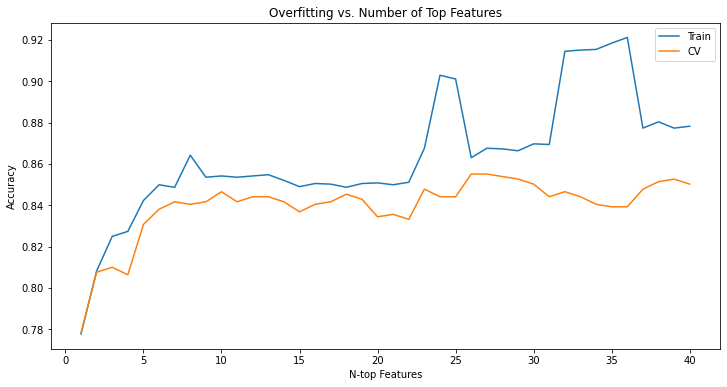

In [18]:
plt.figure(figsize=(12,6))
plt.plot(n_feature_range, train_acc, label='Train')
plt.plot(n_feature_range, cv_acc, label='CV')
plt.xlabel('N-top Features')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Overfitting vs. Number of Top Features');

In [19]:
n_features_keep = 7
features_keep = base_feature_rank.index[0:n_features_keep].tolist()
print(features_keep)

['df_rec_space_mean', 'depth_mean', 'cb_depth_snap_min', 'off_mean', 'dist_shadow_out_play_mean', 'n_deep_frz', 'speed_var']


# EDA of features

In [20]:
# only keep non-duplicate columns
zone_df = labeled_play_df.copy()
# features_keep = ['df_rec_space_mean', 'depth_mean', 'cb_depth_snap_min', 'off_mean',
#        'dist_shadow_out_play_mean', 'n_deep_frz', 'speed_var']
# train test split
y = zone_df.zone
X = zone_df[features_keep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)

## Add Time-to-pass as a feature as part of EDA

In [21]:
def time_to_pass(track_df):
    reduced_df = track_df.groupby('frameId').head(1)
    # find frame of snap
    frame_snap = reduced_df[reduced_df.event=='ball_snap']['frameId'].iloc[0]
    # find frame of pass (or pivot event)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']
    if np.any(reduced_df.event.isin(pivot_events)):
        frame_pass = reduced_df[reduced_df.event.isin(pivot_events)]['frameId'].iloc[0]
    else:
        frame_pass = np.max(reduced_df.frameId)
    
    # return time
    ttp = 0.1 * (frame_pass - frame_snap)
    return ttp

In [22]:
ttp = track_df.groupby(['gameId','playId']).apply(time_to_pass)
ttp.name='ttp'

In [23]:
ttp

gameId      playId
2018090600  75        2.5
            146       2.0
            168       2.3
            190       2.8
            256       2.0
                     ... 
2018091001  3952      3.0
            3976      2.7
            4123      3.6
            4147      1.5
            4192      1.5
Name: ttp, Length: 1034, dtype: float64

In [24]:
ttp_ser = pd.merge(zone_df, ttp.reset_index(), on=['gameId', 'playId'], how='left')['ttp']
df = pd.concat([X.reset_index(drop=True), ttp_ser.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   df_rec_space_mean          1027 non-null   float64
 1   depth_mean                 1027 non-null   float64
 2   cb_depth_snap_min          1027 non-null   float64
 3   off_mean                   1027 non-null   float64
 4   dist_shadow_out_play_mean  1027 non-null   float64
 5   n_deep_frz                 1027 non-null   float64
 6   speed_var                  1027 non-null   float64
 7   ttp                        1027 non-null   float64
 8   zone                       1027 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 72.3 KB


In [25]:
df.columns

Index(['df_rec_space_mean', 'depth_mean', 'cb_depth_snap_min', 'off_mean',
       'dist_shadow_out_play_mean', 'n_deep_frz', 'speed_var', 'ttp', 'zone'],
      dtype='object')

# EDA of features

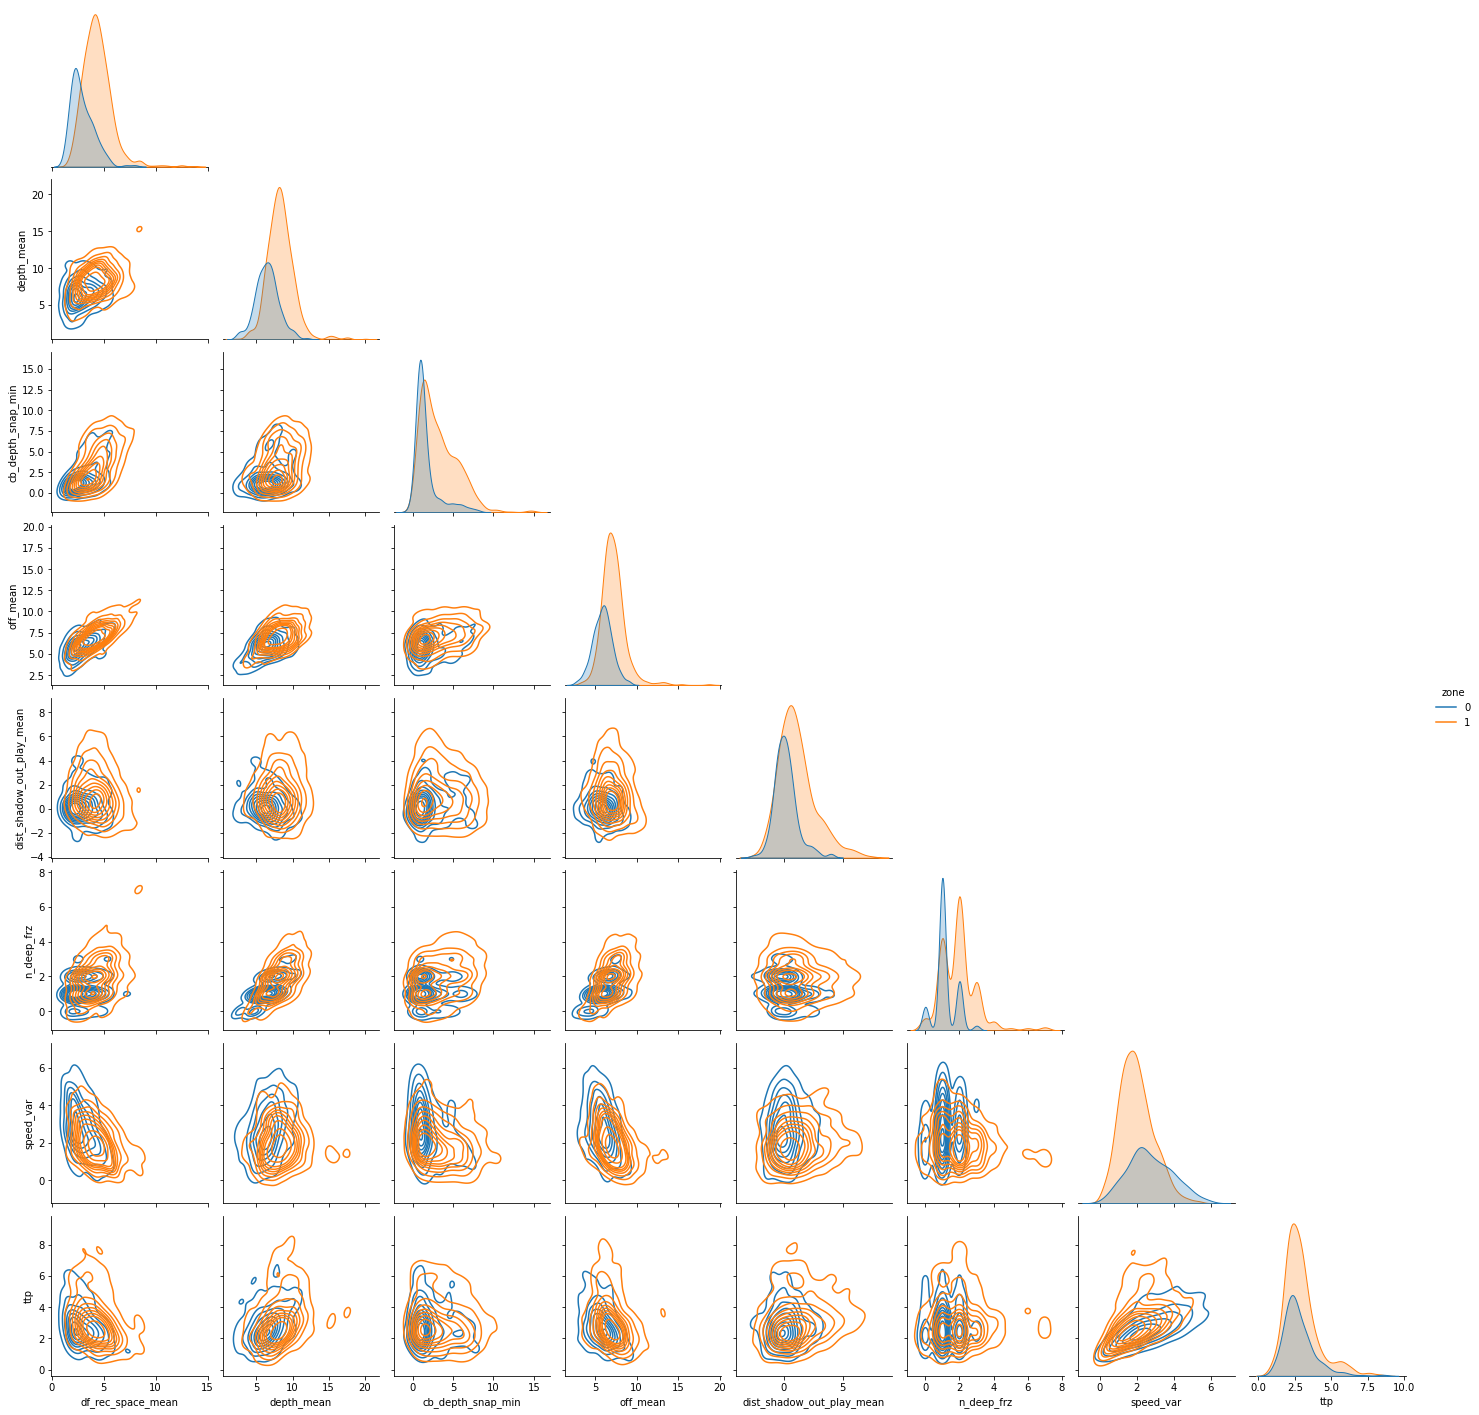

In [26]:
sns.pairplot(data=df, hue='zone', kind='kde', corner=True);

# SVC of simplified feature set

In [27]:
# build pipeline
estimators_svc = [('normalize', StandardScaler()),
              ('clf', SVC())]
pipe_svc = Pipeline(estimators_svc)

# build grid search
param_grid_svc = [
    {
        'clf': [LinearSVC(random_state=123456)],
#         'clf__penalty': ['l2'],
#         'clf__loss': ['hinge','squared-hinge'],
        'clf__class_weight': [None, 'balanced']
    },
    {
        'clf': [SVC(random_state=123456)],
        'clf__kernel': ['poly', 'rbf', 'sigmoid'],
    #     'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
        'clf__class_weight': [None, 'balanced']
}]

# train model
clf_svcu = GridSearchCV(pipe_svc, param_grid=param_grid_svc, return_train_score=True)
clf_svcu.fit(X_train, y_train)
print(f'Train accuracy: {clf_svcu.cv_results_["mean_train_score"][clf_svcu.best_index_]:.3f}')
print(f'CV test accuracy: {clf_svcu.cv_results_["mean_test_score"][clf_svcu.best_index_]:.3f}')

Train accuracy: 0.848
CV test accuracy: 0.839


In [28]:
clf_svcu.best_params_

{'clf': LinearSVC(random_state=123456), 'clf__class_weight': None}

In [29]:
y_svcu_pred = clf_svcu.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_svcu_pred):.3f}')
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_test, y_svcu_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone'])

Test accuracy: 0.825
Confusion Matrix: 


,Pred. Man,Pred. Zone
Actual Man,45,23
Actual Zone,13,125


# NEXT UP

**To-Do:**

* Investigate data to create new features to better predict man coverage
    * mischaracterizations are not edge cases (e.g. at the end-zone). No relation to down, distance, quarter, or location on field. Lots of mischaracterizations occur in the middle of the field (i.e. all but 3 are outside the 15 yd line so compression from the endzone is not the cause). Also there does not seem to be a strong correlation with time to throw (i.e. mischaracterizing on quick throws only, etc.)
    * maybe game situation? (3rd & short: more likely press coverage)
    * do a flip of distance-to definition: instead of defender-to-X, do receiver-to-defender for those downfield at freeze time.  This way defenders that are in zone or spy do not skew results, and only look at receivers running routes.

**Completed:**

* Look at higher t_scheme_develop values > 4 sec
    * No meaningful impact > 4 sec
* Change the rat_o_los calculator to use a much lower angle as facing the line of scrimmage (e.g. 60 deg cone: 240-300 deg instead of 180-360 deg)
    * Larger range of values but does not seem to materially impact accuracy
* Allow a buffer time after the "throw" event to account for reaction time (i.e. players continuing to do their assignment until they realize the ball has been thrown). Since the accuracy tends to go up as t_scheme_develop goes up, longer periods of data seem to give better predictive results.
    * Does not appear to impact the results